Import needed stuff

In [1]:
import requests
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
from matplotlib import pyplot as plt
import seaborn as sns
import networkscience as ns
import pycountry as pc

Downloading data by http request

In [2]:
reply = requests.get('https://data.europa.eu/euodp/data/storage/f/2020-08-11T140550/Finalised%20mobilities%20started%20in%202018%20-%20KA1.csv')
reply.encoding = 'utf-8'
csv_data = reply.text
df = pd.read_csv(StringIO(csv_data), sep=';',low_memory=False)

## Mobility of Countries
In this section we want to analyze how musch different countries are involved in the Erasmus program.

I am not sure there are enought node to have a sensible analysis of the problem.

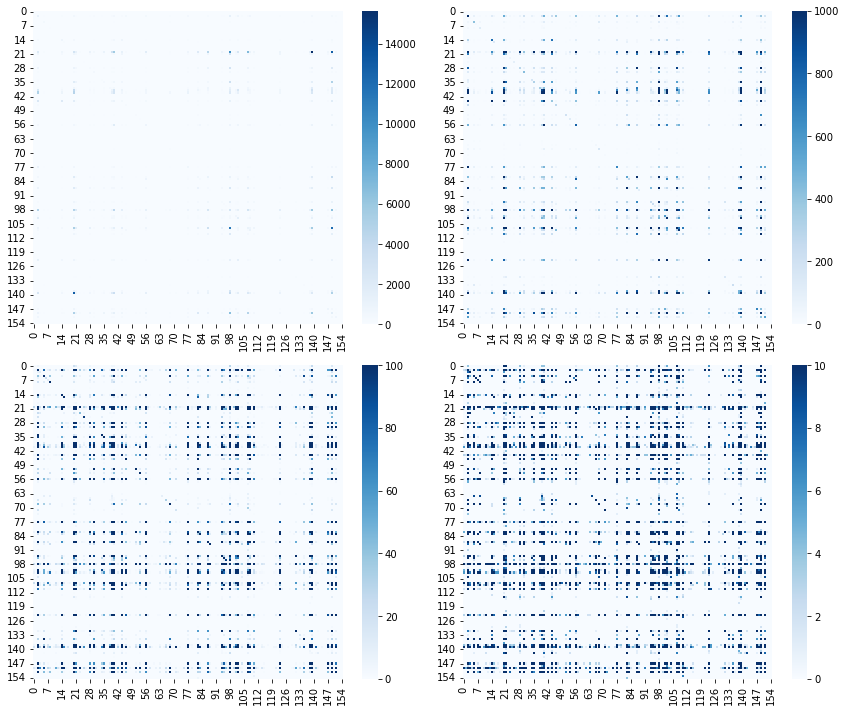

In [3]:
country_df = df[df[df.columns[10]]=='Learner']
country_df = country_df.loc[:, df.columns[np.array((14, 17, 20))]]
country_df.dropna(how='any', inplace=True)
nodes = np.array(list(set.union(set(country_df.loc[:, country_df.columns[0]]), set(country_df.loc[:, country_df.columns[1]]))))
# I don't want it to take forever
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
country_df['SendId'] = (np.array(list(map(lambda x: node_position[x], country_df['Sending Country Code']))))
country_df['RecId']= (np.array(list(map(lambda x: node_position[x], country_df['Receiving Country Code']))))
# Adjacency matrix
country_serie = country_df.groupby(['SendId', 'RecId']).sum()
row = np.array(country_serie.index.get_level_values(1).tolist())
col = np.array(country_serie.index.get_level_values(0).tolist())
val = country_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

def replace_iso3166(alpha):
    try:
        return pc.countries.get(alpha_2=alpha).name
    except:
        return alpha

country_df['Receiving Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), country_df['Receiving Country Code']))))
country_df['Sending Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), country_df['Sending Country Code']))))
nodes_df['Nodes'] = (np.array(list(map(lambda x: replace_iso3166(x), nodes_df['Nodes']))))

ns.visualize_adj(adj_matrix_crs)

I would like to understand if the corresponent undirected unwiegthed graph was symmetric, but it is not

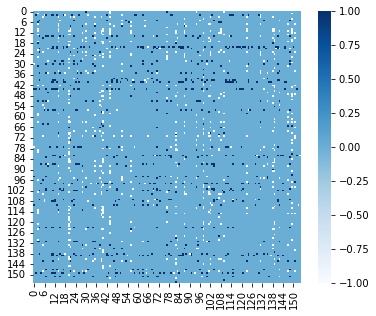

In [4]:
matr = adj_matrix_crs.toarray()
matr[matr>1]=1
matr = matr - matr.T
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(matr, cmap="Blues", ax=ax)
plt.show()


Calculation of the number of components in the network

In [5]:
country_df.rename({'Sending Country Code': 'source', 'Receiving Country Code':'target', 'Participants':'weight'},axis=1, inplace=True)
components = ns.find_components(adj_matrix_crs, nodes_df)
unique, counts = np.unique(components['component'], return_counts=True)
print('Number of components =', len(unique))

Number of components = 1


### Degree distribution

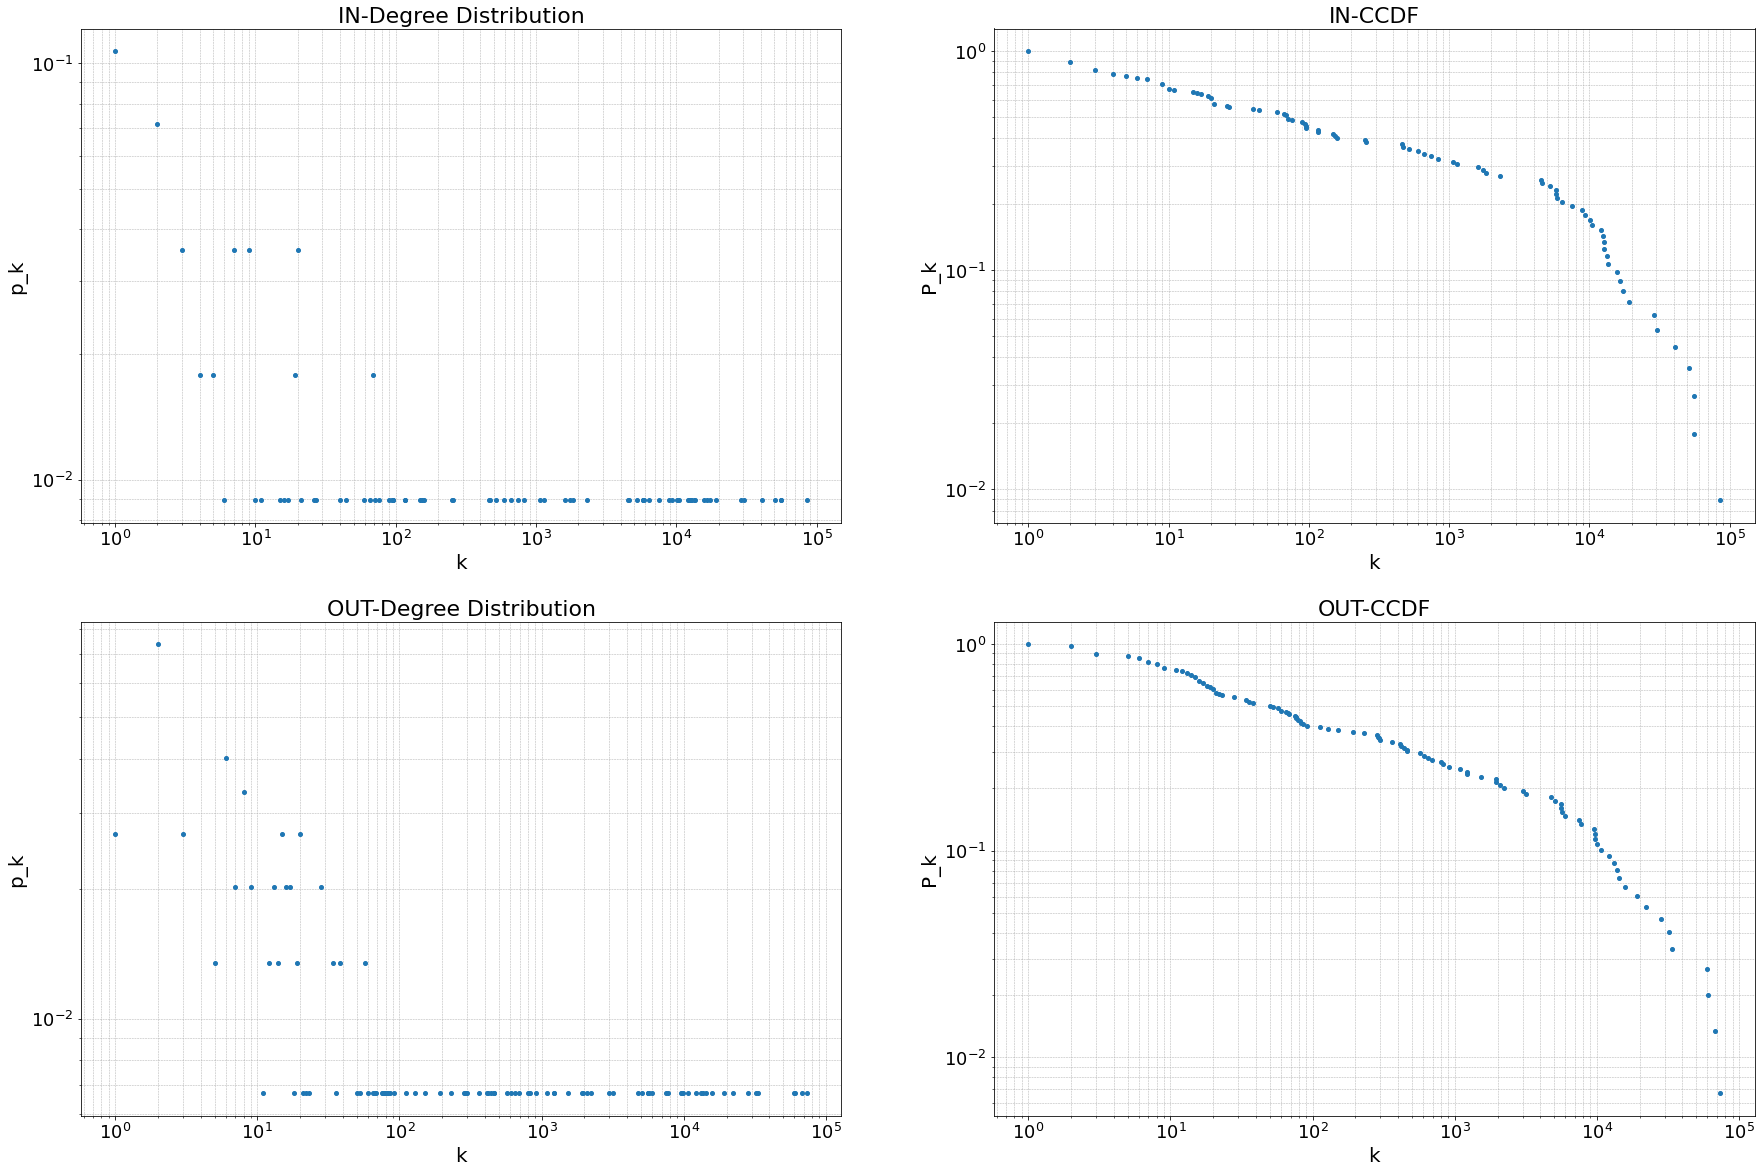

Top 10 for in degree


,Nodes,in degree
20,Spain,85255
107,UK,55556
98,Germany,55489
139,Italy,50912
149,France,40840
40,Poland,30154
39,Portugal,28984
87,Netherlands,19163
35,Ireland,17474
44,Czechia,16559


Top 10 for out degree


,Nodes,out degree
149,France,73481
98,Germany,67772
139,Italy,60222
20,Spain,59413
2,Turkey,33511
40,Poland,32388
107,UK,28448
87,Netherlands,22090
102,Romania,19294
39,Portugal,15750


In [6]:
scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
ns.display_top_n(scores, 10, 'in degree')
ns.display_top_n(scores, 10, 'out degree')

### HITS (NetworkX)

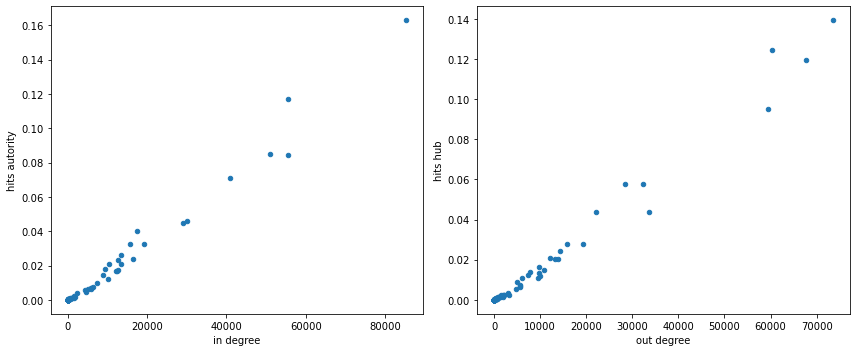

Top 10 for hits hub


,Nodes,hits hub
149,France,0.139283
139,Italy,0.124679
98,Germany,0.119749
20,Spain,0.094932
107,UK,0.057723
40,Poland,0.057705
87,Netherlands,0.043805
2,Turkey,0.043587
102,Romania,0.027973
39,Portugal,0.027626


Top 10 for hits autority


,Nodes,hits autority
20,Spain,0.162843
107,UK,0.117227
139,Italy,0.085113
98,Germany,0.084523
149,France,0.071154
40,Poland,0.046151
39,Portugal,0.044684
35,Ireland,0.040060
82,Belgium,0.032396
87,Netherlands,0.032326


In [7]:
df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'hits hub')
ns.display_top_n(scores, 10, 'hits autority')

### PageRank (NetworkX)

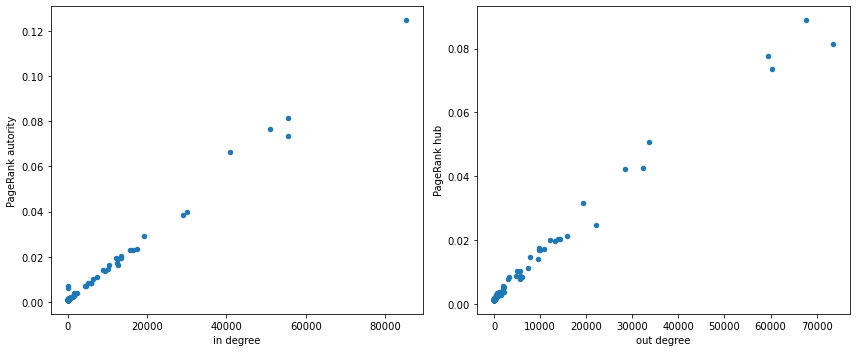

Top 10 for PageRank hub


,Nodes,PageRank hub
98,Germany,0.088870
149,France,0.081390
20,Spain,0.077764
139,Italy,0.073692
2,Turkey,0.050792
40,Poland,0.042699
107,UK,0.042150
102,Romania,0.031626
87,Netherlands,0.024640
39,Portugal,0.021385


Top 10 for PageRank autority


,Nodes,PageRank autority
20,Spain,0.124574
98,Germany,0.081602
139,Italy,0.076687
107,UK,0.073659
149,France,0.066544
40,Poland,0.040025
39,Portugal,0.038717
87,Netherlands,0.029240
35,Ireland,0.023405
44,Czechia,0.023160


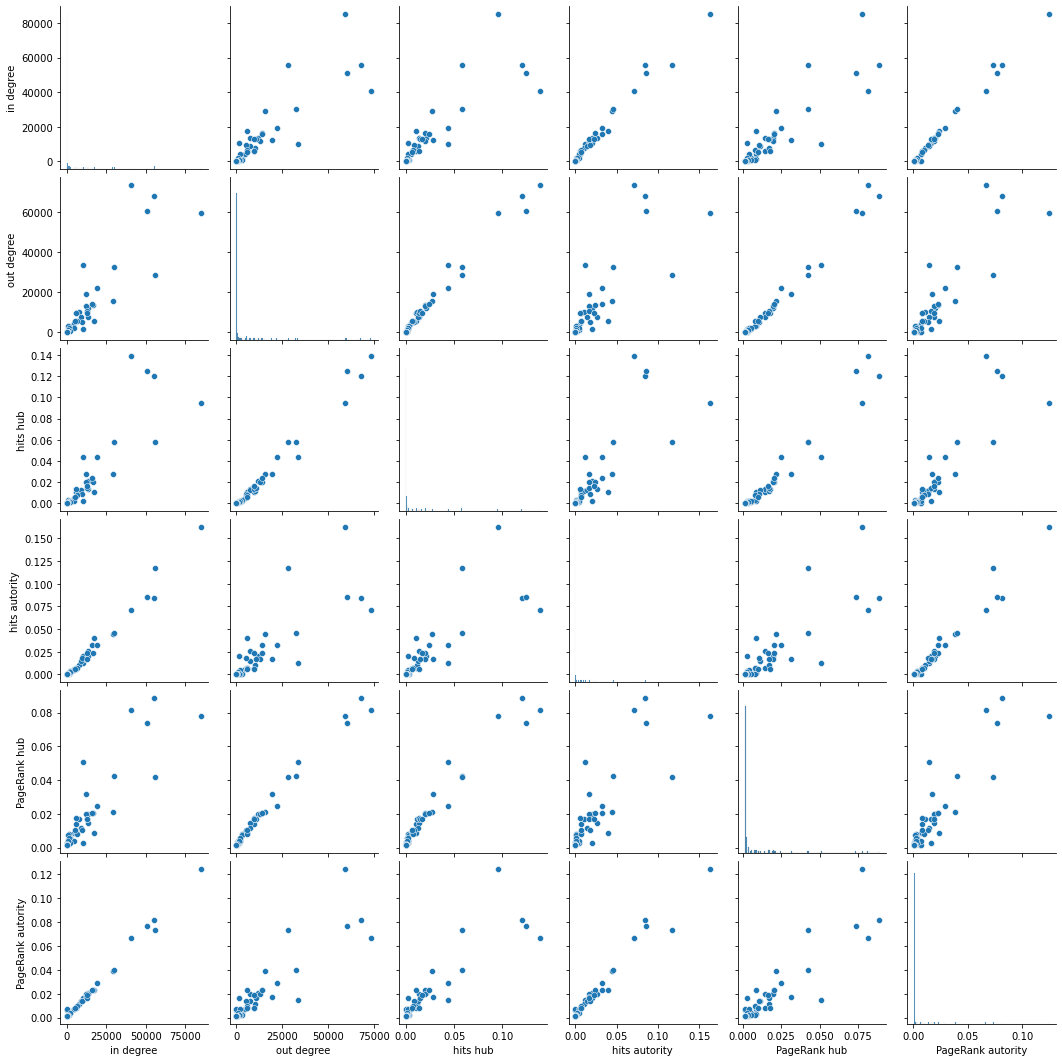

In [8]:
df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'PageRank hub')
ns.display_top_n(scores, 10, 'PageRank autority')

sns.pairplot(scores)
plt.show()

In [9]:
def create_position(score_df, label):
    scores = score_df.sort_values(label, ascending=False)
    scores[label+' position']= (np.arange(len(scores.index))+1)
    return scores

scores = create_position(scores, 'in degree')
scores = create_position(scores, 'out degree')
scores = create_position(scores, 'hits hub')
scores = create_position(scores, 'hits autority')
scores = create_position(scores, 'PageRank hub')
scores = create_position(scores, 'PageRank autority')
scores.sort_index(inplace=True)

In [10]:
n = 40
pd.set_option('display.max_rows', n)
display(scores.sort_values('PageRank autority', ascending=False)[['Nodes', 'in degree', 'in degree position', 'hits autority', 'hits autority position', 'PageRank autority', 'PageRank autority position']].head(n))
display(scores.sort_values('PageRank hub', ascending=False)[['Nodes', 'out degree', 'out degree position', 'hits hub', 'hits hub position', 'PageRank hub', 'PageRank hub position']].head(n))

,Nodes,in degree,in degree position,hits autority,hits autority position,PageRank autority,PageRank autority position
20,Spain,85255,1,0.162843,1,0.124574,1
98,Germany,55489,3,0.084523,4,0.081602,2
139,Italy,50912,4,0.085113,3,0.076687,3
107,UK,55556,2,0.117227,2,0.073659,4
149,France,40840,5,0.071154,5,0.066544,5
40,Poland,30154,6,0.046151,6,0.040025,6
39,Portugal,28984,7,0.044684,7,0.038717,7
87,Netherlands,19163,8,0.032326,10,0.029240,8
35,Ireland,17474,9,0.040060,8,0.023405,9
44,Czechia,16559,10,0.023774,12,0.023160,10


,Nodes,out degree,out degree position,hits hub,hits hub position,PageRank hub,PageRank hub position
98,Germany,67772,2,0.119749,3,0.088870,1
149,France,73481,1,0.139283,1,0.081390,2
20,Spain,59413,4,0.094932,4,0.077764,3
139,Italy,60222,3,0.124679,2,0.073692,4
2,Turkey,33511,5,0.043587,8,0.050792,5
40,Poland,32388,6,0.057705,6,0.042699,6
107,UK,28448,7,0.057723,5,0.042150,7
102,Romania,19294,9,0.027973,9,0.031626,8
87,Netherlands,22090,8,0.043805,7,0.024640,9
39,Portugal,15750,10,0.027626,10,0.021385,10


### Assortativity
We have to check if this disassortativity is due to structural reason, because it looks weird. It is almost the opposit of what we saw for the complete network.

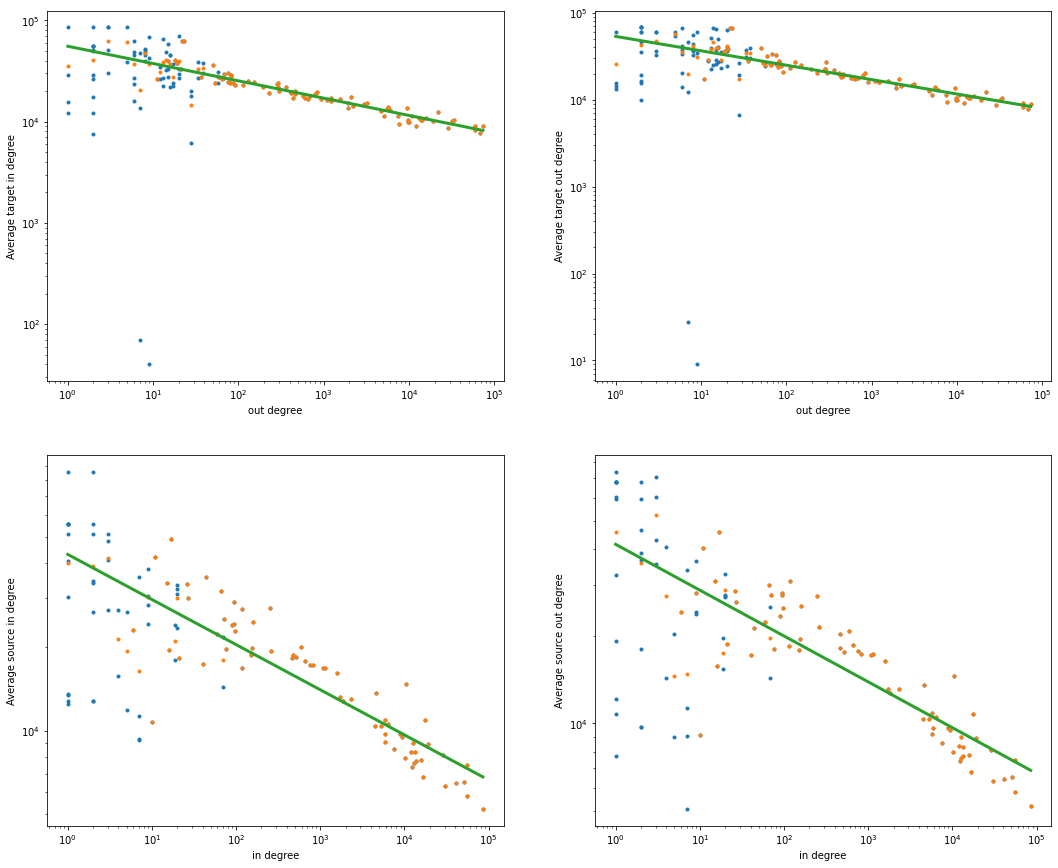

(-0.1709131474314809,
 -0.16566416781192514,
 -0.16258008251223896,
 -0.15802291954725187)

In [11]:
edges = country_df[['source','target']].copy()
ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True)

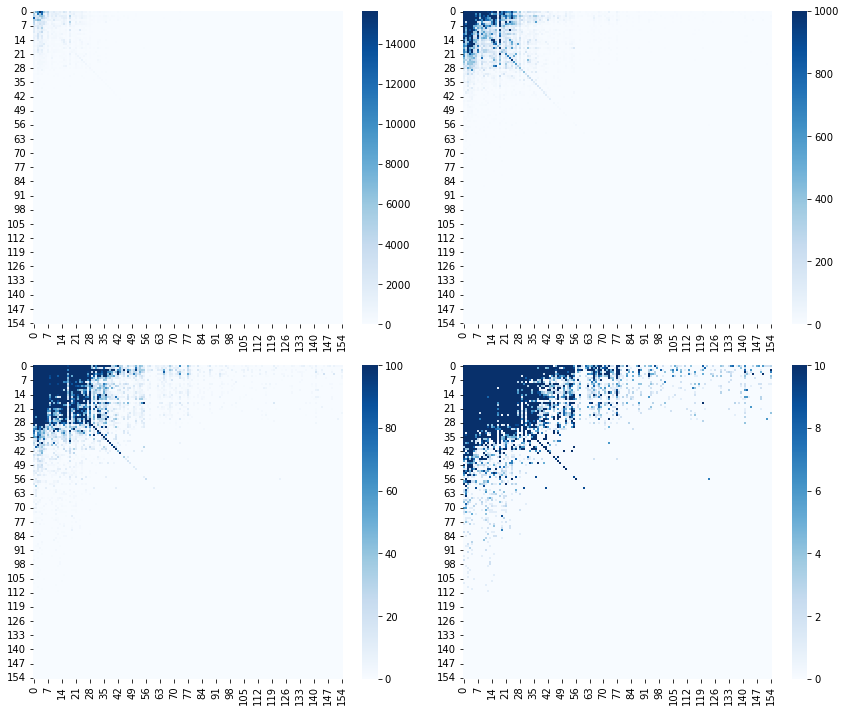

In [12]:
# label = 'PageRank autority position'
label = 'in degree position'
c = country_df.drop(['SendId', 'RecId'],axis=1)
another_order = scores[['Nodes', label]].copy()
another_order[label] = another_order[label] - 1
another_order.rename({'Nodes':'source', label: 'source ID'}, axis=1, inplace=True)
c = pd.merge(c, another_order, on="source")
another_order.rename({'source':'target', 'source ID': 'target ID'}, axis=1, inplace=True)
c = pd.merge(c, another_order, on="target")
c_serie = c.groupby(['source ID', 'target ID']).sum()
row = np.array(c_serie.index.get_level_values(1).tolist())
col = np.array(c_serie.index.get_level_values(0).tolist())
val = c_serie.values
or_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

ns.visualize_adj(or_adj)

The plot highlights differences between the adjacency matrix and the transpose one. It can explain disassortativity.

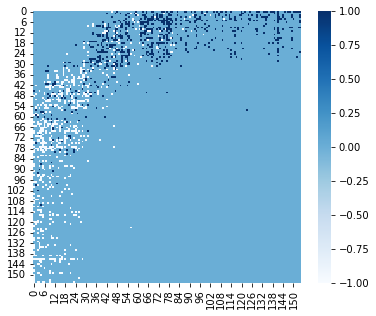

In [13]:
matr = or_adj.toarray()
matr[matr>1]=1
matr = matr - matr.T
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(matr, cmap="Blues", ax=ax)
plt.show()

This is only a draft version of community detection

In [14]:
import networkx as nx
# import community

G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix_crs)
p = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)
node_comm = nodes_df.copy()

node_comm['Community']=np.zeros(len(node_comm.index),dtype='int8')
for i, set in enumerate(p):
    for element in set:
        node_comm.iat[element, 1]=i
for i, set in enumerate(p):
    display(node_comm[node_comm['Community']==i])


,Nodes,Community
4,Burkina Faso,0
10,Mongolia,0
13,Kyrgyzstan,0
18,Hong Kong,0
19,Angola,0
...,...,...
144,Cameroon,0
145,Costa Rica,0
146,Suriname,0
149,France,0


,Nodes,Community
5,Georgia,1
7,Egypt,1
8,"Moldova, Republic of",1
14,Slovakia,1
15,Morocco,1
22,Sudan,1
30,Estonia,1
34,Bosnia and Herzegovina,1
35,Ireland,1
38,Malta,1


,Nodes,Community
0,United States,2
1,Ecuador,2
9,Gambia,2
11,Kazakhstan,2
12,South Africa,2
17,Uzbekistan,2
24,Uganda,2
42,Algeria,2
44,Czechia,2
48,Brazil,2


,Nodes,Community
16,Lao People's Democratic Republic,3
23,Tunisia,3
25,"Palestine, State of",3
27,El Salvador,3
28,Sweden,3
63,India,3
81,Jamaica,3
99,"Bolivia, Plurinational State of",3
110,Norway,3
113,Sri Lanka,3


,Nodes,Community
70,Aruba,4
76,Rwanda,4
82,Belgium,4
100,China,4
143,"Congo, The Democratic Republic of the",4
152,Nicaragua,4
154,French Polynesia,4


,Nodes,Community
2,Turkey,5
3,Lebanon,5
6,Sint Maarten (Dutch part),5
55,Montserrat,5
59,Bangladesh,5
80,Afghanistan,5


## Geographic Heat map 

<AxesSubplot:>

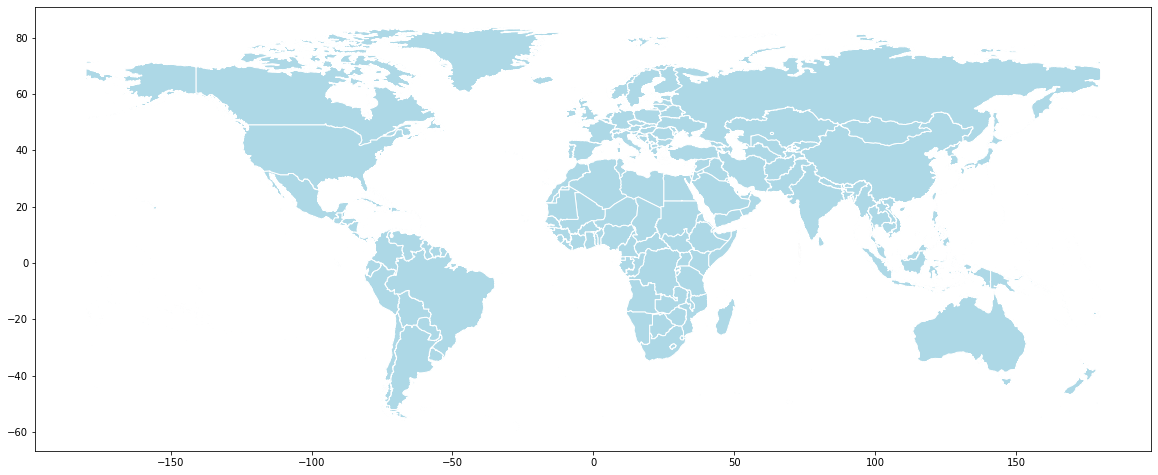

In [15]:
import geopandas as gpd

# Setting the path to the shapefile
# shapefile = 'ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp'

# Read shapefile using Geopandas
# geo_df = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
geo_df = gpd.read_file('countries.geojson')

# geo_df['geometry'][geo_df['ADMIN'] == 'France'] = geo2_df['geometry'][geo2_df['ADMIN'] == 'France']
def replace_iso2(alpha):
    try:
        return pc.countries.get(alpha_3=alpha).alpha_2
    except:
        return alpha
    
geo_df['iso2_code']= (np.array(list(map(lambda x: replace_iso2(x), geo_df['ISO_A3']))))

# Rename columns
geo_df.columns = ['country', 'country_code', 'geometry', 'iso2_code']

# Drop row for 'Antarctica'. It takes a lot of space in the map and is not of much use
geo_df = geo_df.drop(geo_df.loc[geo_df['country'] == 'Antarctica'].index)

# Print the map
geo_df.plot(figsize=(20, 20), edgecolor='white', linewidth=1, color='lightblue')

C:\Users\tomma\AppData\Local\Temp/ipykernel_19936/2872757169.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_df['iso2_code'][geo_df['country'] == 'United Kingdom'] = 'UK'
C:\Users\tomma\AppData\Local\Temp/ipykernel_19936/2872757169.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_df['iso2_code'][geo_df['country'] == 'Greece'] = 'EL'
C:\Users\tomma\AppData\Local\Temp/ipykernel_19936/2872757169.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

(-198.0, 198.0000000000002, -66.62809417064985, 90.78944326365011)

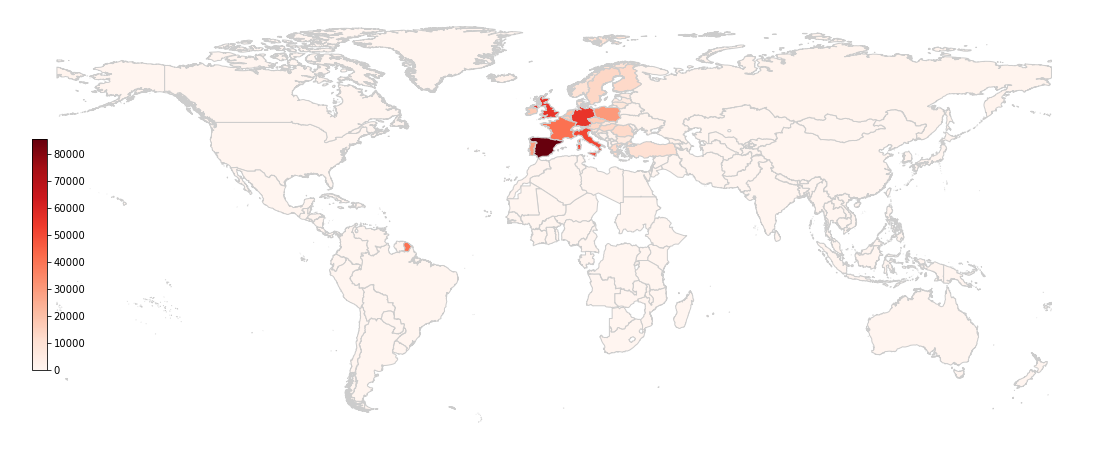

In [16]:
# import country_converter as coco

fig, ax = plt.subplots(1, figsize=(20, 8))

# adding code country to scores dataframe
countries_codes = nodes_df
countries_codes['code'] = nodes
scores_merge = pd.merge(left=countries_codes, right=scores, how='right', left_on='Nodes', right_on='Nodes')

# geo_df contains iso3 codes so we need to convert them to iso2
# geo_df['iso2_code'] = coco.convert(names=list(geo_df['country']), to='ISO2', not_found='NULL')
# geo_df = geo_df.drop(geo_df.loc[geo_df['iso2_code'] == 'NULL'].index)

# in geo_df United Kingdom has code GB, so we have to change it manually
geo_df['iso2_code'][geo_df['country'] == 'United Kingdom'] = 'UK'
geo_df['iso2_code'][geo_df['country'] == 'Greece'] = 'EL'
geo_df['iso2_code'][geo_df['country'] == 'Kosovo'] = 'XK'
geo_df['country'][geo_df['country'] == 'Czech Republic'] = 'Czechia'
geo_df['country'][geo_df['country'] == 'Republic of Serbia'] = 'Serbia'

# adding Switzerland since there is no Erasmus data
sw = {'Nodes':'Switzerland', 'code':'CH', 'in degree':0, 'out degree':0, 'hits hub':0, 'hits autority':0,
       'PageRank hub':0, 'PageRank autority':0, 'in degree position':0,
       'out degree position':0, 'hits hub position':0, 'hits autority position':0,
       'PageRank hub position':0, 'PageRank autority position':0}
scores_merge = scores_merge.append(sw, ignore_index = True)

merged_df = pd.merge(left=geo_df, right=scores_merge, how='right', left_on='iso2_code', right_on='code')
merged_df.dropna(subset=['Nodes'], inplace=True)
merged_df.plot(column='in degree', ax=ax, edgecolor='0.8', linewidth=1, cmap='Reds')

sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=merged_df['in degree'].min(), 
                                              vmax=merged_df['in degree'].max()), cmap='Reds')

# Empty array for the data range
sm._A = []

# Add the colorbar to the figure
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)
ax.axis('off')

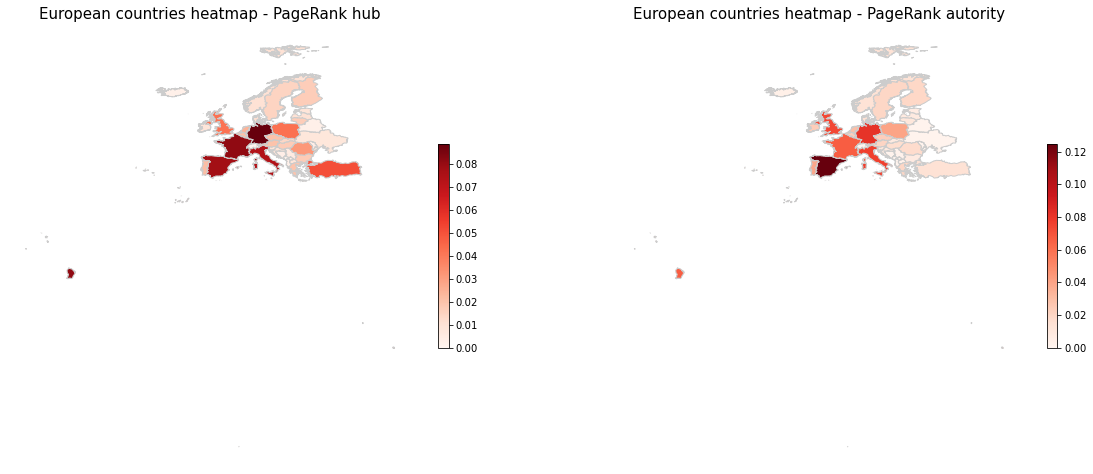

In [17]:
european_countries = ['Germany', 'United Kingdom', 'France', 'Italy', 'Spain', 'Ukraine', 'Poland', 'Romania', 
                'Netherlands', 'Belgium', 'Czechia', 'Greece', 'Portugal', 'Sweden', 'Hungary', 
                'Belarus', 'Austria', 'Serbia', 'Switzerland', 'Bulgaria', 'Denmark', 'Finland', 'Slovakia', 'Norway',
                'Ireland', 'Croatia', 'Moldova', 'Bosnia and Herzegovina', 'Albania', 'Lithuania', 'Macedonia', 
                'Slovenia', 'Latvia', 'Estonia', 'Montenegro', 'Luxembourg', 'Malta', 'Iceland', 'Andorra', 'Monaco', 
                'Liechtenstein', 'Kosovo', 'Turkey']
# Russia has not been taken in consideration since it was too big to show and has very low exchanges

european_df = merged_df[merged_df['country'].isin(european_countries)]

# deg_list = ['in degree', 'out degree', 'PageRank hub', 'PageRank autority']
#fig4, ax4 = plt.subplots(1,4, figsize=(20,15))
deg_list = ['PageRank hub', 'PageRank autority']
fig4, ax4 = plt.subplots(1,2, figsize=(20,15))

for i in range(len(deg_list)):
    european_df.plot(column=deg_list[i], ax=ax4[i], edgecolor='0.8', linewidth=1, cmap='Reds')
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=european_df[deg_list[i]].min(), 
                                              vmax=european_df[deg_list[i]].max()), cmap='Reds')
    ax4[i].axis('off')
    fig4.colorbar(sm, ax=ax4[i], shrink=0.25)
    ax4[i].set_title('European countries heatmap - ' + deg_list[i], fontsize=15)
    
# ax4 = np.reshape(ax4, (2,2))
plt.savefig('eu_pagerank.png')

GeoPlot for Communities

In [ ]:
node_comm['Nodes'][node_comm['Nodes'] == 'Moldova, Republic of'] = 'Moldova'
node_comm['Nodes'][node_comm['Nodes'] == 'North Macedonia'] = 'Macedonia'
node_comm['Nodes'][node_comm['Nodes'] == 'XK'] = 'Kosovo'

eu_comm = node_comm[node_comm['Nodes'].isin(european_countries)]
european_df['Community'] = eu_comm['Community']

fig5, ax5 = plt.subplots(figsize=(20,15))
european_df.plot(column='Community', ax=ax5, edgecolor='0.8', linewidth=1, cmap='jet')
ax5.axis('off')
ax5.set_title('European countries - Commmunity', fontsize=15)

plt.savefig('eu_community.png')

C:\Users\tomma\AppData\Local\Temp/ipykernel_19936/1314837684.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_comm['Nodes'][node_comm['Nodes'] == 'Moldova, Republic of'] = 'Moldova'
C:\Users\tomma\AppData\Local\Temp/ipykernel_19936/1314837684.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_comm['Nodes'][node_comm['Nodes'] == 'North Macedonia'] = 'Macedonia'
C:\Users\tomma\AppData\Local\Temp/ipykernel_19936/1314837684.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu